In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_66_228_106_397_129.mat
/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_29_387_75_244_333.mat
/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_34_165_293_310_306.mat
/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_39_532_452_87_112.mat
/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_9_447_493_436_201.mat
/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_55_132_223_51_422.mat
/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_51_437_185_520_158.mat
/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_22_327_62_397_150.mat
/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_34_78_64_39_160.mat
/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_28_29_110_474_133.mat
/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_13_125_199_488_378.mat
/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_11_81_340_259_162.mat
/kaggle/input/dataset-hfw/Combined Dat

In [2]:
import shutil
shutil.rmtree("/kaggle/working/output_W.mat")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/output_W.mat'

# *Main Code (Based on ANN)*

In [3]:
## Edition 0.1

## Edition 2.2(main code)

## Code runs perfectly, but here complex are considerd as real(i.e. imaginary parts are ignored)
## Might need to correct this error.


import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch.cuda.amp as amp
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
    
class ComplexReLU(nn.Module):
    def forward(self, input):
        # Convert input to complex data type
        input = torch.complex(input, torch.zeros_like(input))
        
        # Custom complex ReLU: ReLU separately for real and imaginary parts
        real_relu = torch.relu(input.real)
        imag_relu = torch.relu(input.imag)
        return torch.complex(real_relu, imag_relu)
class ComplexTanH(nn.Module):
    def forward(self, input):
        # Convert input to complex data type
        input = torch.complex(input, torch.zeros_like(input))
        
        # Custom complex ReLU: ReLU separately for real and imaginary parts
        real_relu = torch.tanh(input.real)
        imag_relu = torch.tanh(input.imag)
        return torch.complex(real_relu, imag_relu)


class ComplexNet(nn.Module):
    #def __init__(self, input_size, output_size):
    def __init__(self, input_size, output_size1, output_size2):
        super(ComplexNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc_output1 = nn.Linear(32, output_size1)  # Linear layer for output1
        self.fc_output2 = nn.Linear(32, output_size2)  # Linear layer for output2
        self.relu = ComplexTanH()  # Use the custom complex ReLU

    def forward(self, x):
        #with amp.autocast():
                # Perform data type conversion and ensure compatibility
        x = x.to(torch.complex64)  # Convert input to ComplexFloat
        x = self.fc1(x.to(torch.float32))  # Perform the first linear transformation
        x = self.relu(x.to(torch.float32))  # Apply ReLU activation
        x = self.fc2(x.to(torch.float32))  # Perform the second linear transformation
        x = self.relu(x.to(torch.float32))  # Apply ReLU activation

        output1 = self.fc_output1(x.to(torch.float32))  # Final linear transformation for output1
        output2 = self.fc_output2(x.to(torch.float32))  # Final linear transformation for output2
        return output1, output2

In [4]:
!pip install torchsummary

In [5]:
model = ComplexNet(51840, output_size1 = 2880, output_size2 = 720).to('cuda')

In [20]:
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
input_size = 51840
output_size1 = 2880
output_size2 = 720

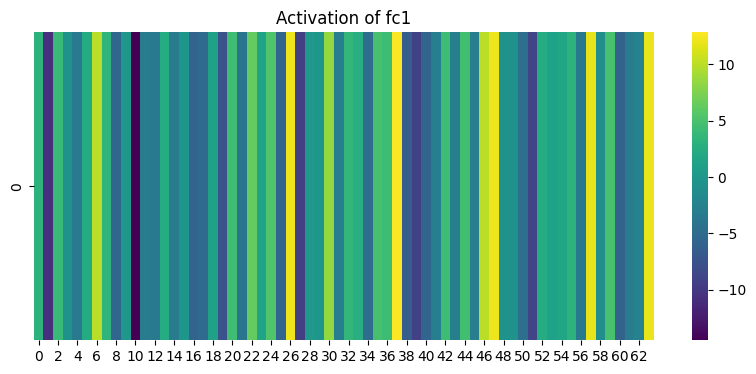

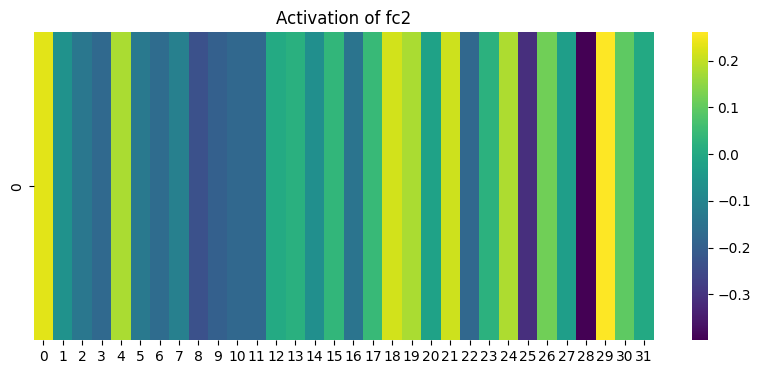

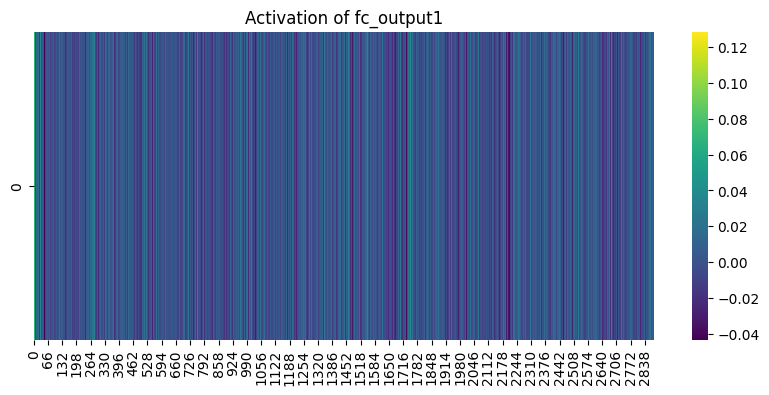

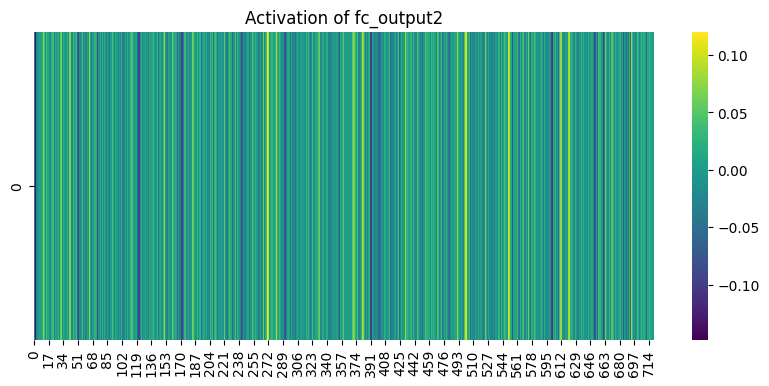

In [28]:
model.fc1.register_forward_hook(get_activation('fc1'))
model.fc2.register_forward_hook(get_activation('fc2'))
model.fc_output1.register_forward_hook(get_activation('fc_output1'))
model.fc_output2.register_forward_hook(get_activation('fc_output2'))

# Dummy input
input_data = torch.randn(1, input_size)

# Forward pass
output1, output2 = model(input_data.to(device))

# Plotting the activations
for layer_name, activation in activations.items():
    plt.figure(figsize=(10, 4))
    sns.heatmap(activation.cpu().numpy(), annot=False, fmt=".2f", cmap='viridis')
    plt.title(f'Activation of {layer_name}')
    plt.show()

In [6]:
from torchsummary import summary
summary(model, input_size=(1,51840))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]       3,317,824
       ComplexTanH-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 32]           2,080
       ComplexTanH-4                [-1, 1, 32]               0
            Linear-5              [-1, 1, 2880]          95,040
            Linear-6               [-1, 1, 720]          23,760
Total params: 3,438,704
Trainable params: 3,438,704
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 0.03
Params size (MB): 13.12
Estimated Total Size (MB): 13.34
----------------------------------------------------------------


/tmp/ipykernel_34/4163694868.py:53: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/Copy.cpp:299.)
  x = self.fc1(x.to(torch.float32))  # Perform the first linear transformation


In [7]:
def load_data(data_folder):
    input_folder = os.path.join(data_folder, "Combined Dataset", "Input")
    output1_folder = os.path.join(data_folder, "Combined Dataset", "Output1")
    output2_folder = os.path.join(data_folder, "Combined Dataset", "Output2")
    
    input_files = [os.path.join(input_folder, file) for file in os.listdir(input_folder)]
    output1_files = [os.path.join(output1_folder, file) for file in os.listdir(output1_folder)]
    output2_files = [os.path.join(output2_folder, file) for file in os.listdir(output2_folder)]
    
    return input_files, output1_files, output2_files

In [8]:
def load_mat_file(file_path, key):
    mat_data = loadmat(file_path)
    return torch.tensor(mat_data[key], dtype=torch.complex64)

In [9]:
def process_data(input_files, output1_files, output2_files):
    input_real = []
    input_imag = []
    output1_real = []
    output1_imag = []
    output2_real = []
    output2_imag = []

    for i in range(len(input_files)):
        input_data = load_mat_file(input_files[i], 'H')
        output1_data = load_mat_file(output1_files[i], 'Fopt_final')
        output2_data = load_mat_file(output2_files[i], 'Wopt_final')

        input_real.append(input_data.real)
        input_imag.append(input_data.imag)
        output1_real.append(output1_data.real)
        output1_imag.append(output1_data.imag)
        output2_real.append(output2_data.real)
        output2_imag.append(output2_data.imag)

    # Check if any of the lists is empty
#    if not any(input_real):
#        raise ValueError("Input real data list is empty")
#    if not any(input_imag):
#        raise ValueError("Input imaginary data list is empty")
 #   if not any(output1_real):
#        raise ValueError("Output1 real data list is empty")
#    if not any(output1_imag):
#        raise ValueError("Output1 imaginary data list is empty")
#    if not any(output2_real):
#        raise ValueError("Output2 real data list is empty")
#    if not any(output2_imag):
#        raise ValueError("Output2 imaginary data list is empty")

    input_real = torch.stack(input_real)
    input_imag = torch.stack(input_imag)
    output1_real = torch.stack(output1_real)
    output1_imag = torch.stack(output1_imag)
    output2_real = torch.stack(output2_real)
    output2_imag = torch.stack(output2_imag)

    return input_real, input_imag, output1_real, output1_imag, output2_real, output2_imag

In [10]:
def flatten_data(input_real, input_imag, output1_real, output1_imag, output2_real, output2_imag):
    input_real_flat = input_real.view(input_real.size(0), -1)
    input_imag_flat = input_imag.view(input_imag.size(0), -1)
    output1_real_flat = output1_real.view(output1_real.size(0), -1)
    output1_imag_flat = output1_imag.view(output1_imag.size(0), -1)
    output2_real_flat = output2_real.view(output2_real.size(0), -1)
    output2_imag_flat = output2_imag.view(output2_imag.size(0), -1)

    return input_real_flat, input_imag_flat, output1_real_flat, output1_imag_flat, output2_real_flat, output2_imag_flat

In [11]:
def combine_data(input_real_flat, input_imag_flat, output1_real_flat, output1_imag_flat, output2_real_flat, output2_imag_flat):
    input_combined = torch.cat((input_real_flat, input_imag_flat), dim=1)
    output1_combined = torch.cat((output1_real_flat, output1_imag_flat), dim=1)
    output2_combined = torch.cat((output2_real_flat, output2_imag_flat), dim=1)

    return input_combined, output1_combined, output2_combined

In [12]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    t_l = []
    v_l = []
    
    for epoch in range(num_epochs):
        model.train()
        r_loss = 0.0
        for batch_idx, (input_data, output1_data, output2_data) in enumerate(train_loader):
            optimizer.zero_grad()
            input_data = input_data.to(device)
            output1_data = output1_data.to(device)
            output2_data = output2_data.to(device)
            #print(input_data.size())
            predicted_output1, predicted_output2 = model(input_data )
            loss1 = criterion(predicted_output1, output1_data )
            loss2 = criterion(predicted_output2, output2_data )
            loss = loss1 + loss2
            loss.backward()
            optimizer.step()
            r_loss += loss.item()
        train_loss = r_loss/len(train_loader)
            
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')
            
        test_loss = test_model(model, test_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, TstLoss: {test_loss}')
        v_l.append(test_loss), t_l.append(train_loss)
    return predicted_output1, predicted_output2, v_l,t_l

In [13]:
def test_model(model, test_loader):
    model.eval()
    total_accuracy = 0.0
    with torch.no_grad():
        for input_data, output1_data, output2_data in test_loader:
            input_data = input_data.to(device)
            output1_data = output1_data.to(device)
            output2_data = output2_data.to(device)
            predicted_output1, predicted_output2 = model(input_data)
            #print(f"Prediction Output 1:{predicted_output1}, Predicted Output 2:{predicted_output2}")
            accuracy1 = torch.sum(torch.abs(predicted_output1 - (output1_data )) < 0.01).item() / output1_data.numel()
            accuracy2 = torch.sum(torch.abs(predicted_output2 - (output2_data )) < 0.01).item() / output2_data.numel()
            total_accuracy += (accuracy1 + accuracy2) / 2.0
            test_loss1 = criterion(predicted_output1, output1_data )
            test_loss2 = criterion(predicted_output2, output2_data )
            test_loss = test_loss1 + test_loss2

    average_accuracy = total_accuracy / len(test_loader)
    #print(f'Average Accuracy on Test Set: {average_accuracy}')
    return test_loss.item()/len(test_loader)

In [14]:
# Step 1: Load data
data_folder = "/kaggle/input/dataset-hfw"
input_files, output1_files, output2_files = load_data(data_folder)

# Step 2: Process data
input_real, input_imag, output1_real, output1_imag, output2_real, output2_imag = process_data(input_files, output1_files, output2_files)

# Step 3: Flatten data
input_real_flat, input_imag_flat, output1_real_flat, output1_imag_flat, output2_real_flat, output2_imag_flat = flatten_data(input_real, input_imag, output1_real, output1_imag, output2_real, output2_imag)

# Step 4: Combine data
input_combined, output1_combined, output2_combined = combine_data(input_real_flat, input_imag_flat, output1_real_flat, output1_imag_flat, output2_real_flat, output2_imag_flat)

# Step 5: Split data into train and test sets
input_combined_train, input_combined_test, output1_combined_train, output1_combined_test, output2_combined_train, output2_combined_test = train_test_split(input_combined, output1_combined, output2_combined, test_size=0.2, random_state=42)

# Step 6: Define DataLoader for train and test sets
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(input_combined_train, output1_combined_train, output2_combined_train)
test_dataset = torch.utils.data.TensorDataset(input_combined_test, output1_combined_test, output2_combined_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Step 7: Initialize the model, optimizer, and loss function
input_size = input_combined.shape[1]
output_size1 = output1_combined.shape[1]
output_size2 = output2_combined.shape[1]
#model = ComplexNet(input_size, output_size1 = 640, output_size2 = 360).to(device)
model = ComplexNet(input_size, output_size1 = 2880, output_size2 = 720).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)


# Step 8: Train the model
[ pred_out_1, pred_out_2, v_l, t_l ] = train_model(model, train_loader, criterion, optimizer)

# Step 9: Test the model
#[test_pred_out1, test_pred_out2, test_out1, test_out2] = test_model(model, test_loader)

Epoch 1/100, Loss: 0.03446519374847412
Epoch 1/100, TstLoss: 0.002050415612757206
Epoch 2/100, Loss: 0.020732680335640907
Epoch 2/100, TstLoss: 0.0013121237279847264
Epoch 3/100, Loss: 0.01866833120584488
Epoch 3/100, TstLoss: 0.0011713341809809208
Epoch 4/100, Loss: 0.018066968768835068
Epoch 4/100, TstLoss: 0.001129837823100388
Epoch 5/100, Loss: 0.017631014809012413
Epoch 5/100, TstLoss: 0.0011207301868125796
Epoch 6/100, Loss: 0.01746710017323494
Epoch 6/100, TstLoss: 0.0011008036090061069
Epoch 7/100, Loss: 0.01747819595038891
Epoch 7/100, TstLoss: 0.0011038639349862933
Epoch 8/100, Loss: 0.017413020133972168
Epoch 8/100, TstLoss: 0.0010939508210867643
Epoch 9/100, Loss: 0.017478615045547485
Epoch 9/100, TstLoss: 0.0010929610580205917
Epoch 10/100, Loss: 0.017560822889208794
Epoch 10/100, TstLoss: 0.0010893038706853986
Epoch 11/100, Loss: 0.01742638647556305
Epoch 11/100, TstLoss: 0.001092820311896503
Epoch 12/100, Loss: 0.01729528419673443
Epoch 12/100, TstLoss: 0.001093512051738

[]

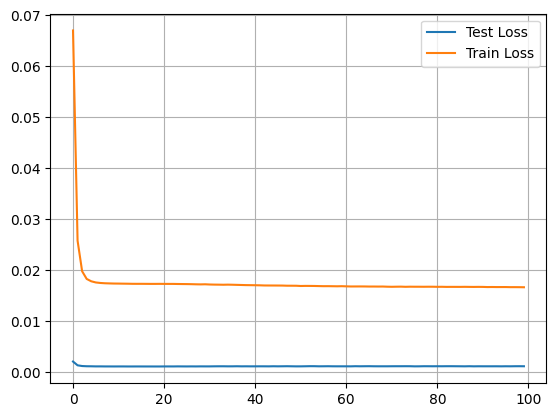

In [15]:
import matplotlib.pyplot as plt
plt.plot(v_l)
plt.plot(t_l)
plt.grid(visible= True)
plt.legend(["Test Loss", "Train Loss"])
plt.plot()

## 36*144*5

In [17]:
import time
st = time.time()
input_files = ["/kaggle/input/dataset-hfw/Combined Dataset/Input/new_u_10_102_253_468_412.mat"]
output1_files = ["/kaggle/input/dataset-hfw/Combined Dataset/Output1/fopt_u_10_102_253_468_412.mat"]
output2_files = ["/kaggle/input/dataset-hfw/Combined Dataset/Output2/wopt_u_10_102_253_468_412.mat"]
i1, i2, i3, i4, i5 , i6 = process_data(input_files, output1_files, output2_files)
i1, i2, i3, i4, i5 , i6 = flatten_data(i1, i2, i3, i4, i5 , i6)
a,b,c = combine_data(i1, i2, i3, i4, i5 , i6)
print(a.shape, b.shape, c.shape)
model.eval()
b_pred, c_pred = model(a.to('cuda'))
print(b_pred.shape, c_pred.shape)
b_pred = (b_pred[:,:1440]+ 1j* b_pred[:,1440:2880]).reshape((144,2, 5))
c_pred =  (c_pred[:,:360]+ 1j* c_pred[:,360:]).reshape((36, 2, 5))
print(b_pred.shape, c_pred.shape)

b = (b[:,:1440]+ 1j* b[:,1440:2880]).reshape((144,2, 5))
c =  (c[:,:360]+ 1j* c[:,360:]).reshape((36, 2, 5))
a =  (a[:,:25920]+ 1j* a[:,25920:]).reshape((36, 144, 5))
print(b.shape, c.shape)


import scipy.io
 
# Assuming your matrix is named 'matrix_data'
matrix_data = b_pred.detach().cpu().numpy()  # Your matrix data
 
# Define the file path where you want to save the .mat file
file_path = 'F1.mat'
 
# Save the matrix to a .mat file
scipy.io.savemat(file_path, {'F_pred': matrix_data})

matrix_data = c_pred.detach().cpu().numpy()  # Your matrix data
 
# Define the file path where you want to save the .mat file
file_path = 'W1.mat'
 
# Save the matrix to a .mat file
scipy.io.savemat(file_path, {'W_pred': matrix_data})


matrix_data = a.detach().cpu().numpy()  # Your matrix data
 
# Define the file path where you want to save the .mat file
file_path = 'H.mat'
 
# Save the matrix to a .mat file
scipy.io.savemat(file_path, {'H': matrix_data})

matrix_data = b.detach().cpu().numpy()  # Your matrix data
 
# Define the file path where you want to save the .mat file
file_path = 'F.mat'
 
# Save the matrix to a .mat file
scipy.io.savemat(file_path, {'F_opt': matrix_data})


matrix_data = c.detach().cpu().numpy()  # Your matrix data
 
# Define the file path where you want to save the .mat file
file_path = 'W.mat'
 
# Save the matrix to a .mat file
scipy.io.savemat(file_path, {'W_opt': matrix_data})





sp = time.time()
print(sp-st)


torch.Size([1, 51840]) torch.Size([1, 2880]) torch.Size([1, 720])
torch.Size([1, 2880]) torch.Size([1, 720])
torch.Size([144, 2, 5]) torch.Size([36, 2, 5])
torch.Size([144, 2, 5]) torch.Size([36, 2, 5])
0.014421463012695312


# Creating Output

In [15]:
test_loader1 = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
## Testing the size of dataset

print(input_real.shape)
print(output1_real.shape)
print(output2_real.shape)

torch.Size([2500, 36, 144, 5])
torch.Size([2500, 144, 2, 5])
torch.Size([2500, 36, 2, 5])


In [17]:
print(test_pred_out1.shape)
#print(out[0].shape)
for data in test_loader1:
    in1 = data[0].to(device)
    ins = in1.size()
    with torch.no_grad():
        out = model(in1)
    out1 = out[0].reshape((ins[0], 5, 144, 4))[:,:,:,:2] + 1j* out[0].reshape((ins[0], 5, 144, 4))[:,:,:,2:4] 
    out2 = out[1].reshape((ins[0], 5, 36, 4))[:,:,:,:2] + 1j* out[1].reshape((ins[0], 5, 36, 4))[:,:,:,2:4] 
    in1 = in1.reshape((ins[0], 10, 36, 144))[:,:5,:,:] + 1j* in1.reshape((ins[0],10, 36, 144))[:,5:10,:,:] 
    print(in1.size())
    print(out1.size())
    print(out2.size())
    
    break

torch.Size([20, 2880])
torch.Size([32, 5, 36, 144])
torch.Size([32, 5, 144, 2])
torch.Size([32, 5, 36, 2])


In [ ]:
'''print(test_pred_out1.shape)
print(out[0].shape)
for data in test_loader1:
    in1 = data[0].to(device)
    ins = in1.size()
    with torch.no_grad():
        out = model(in1)
    out1 = out[0].reshape((ins[0], 5, 16, 8))[:,:,:,:4] + 1j* out[0].reshape((ins[0], 5, 16, 8))[:,:,:,4:8] 
    out2 = out[1].reshape((ins[0], 5, 9, 8))[:,:,:,:4] + 1j* out[1].reshape((ins[0], 5, 9, 8))[:,:,:,4:8] 
    in1 = in1.reshape((ins[0], 9, 16, 10))[:,:,:,:5] + 1j* in1.reshape((ins[0],  9, 16, 10))[:,:,:,5:10] 
    print(in1.size())
    print(out1.size())
    print(out2.size())
    
    break'''


''''torch.Size([32, 640])
torch.Size([500, 640])
torch.Size([500, 9, 16, 5])
torch.Size([500, 5, 16, 4])
torch.Size([500, 5, 9, 4])'''

In [15]:
import scipy.io
 
# Assuming your matrix is named 'matrix_data'
matrix_data = out1.detach().cpu().numpy()  # Your matrix data
 
# Define the file path where you want to save the .mat file
file_path = 'output_F.mat'
 
# Save the matrix to a .mat file
scipy.io.savemat(file_path, {'pred_F': matrix_data})

In [16]:
import scipy.io
 
# Assuming your matrix is named 'matrix_data'
matrix_data = out2.detach().cpu().numpy()  # Your matrix data
 
# Define the file path where you want to save the .mat file
file_path = 'output_W.mat'
 
# Save the matrix to a .mat file
scipy.io.savemat(file_path, {'pred_W': matrix_data})

In [17]:
import scipy.io
 
# Assuming your matrix is named 'matrix_data'
matrix_data = in1.detach().cpu().numpy()  # Your matrix data
 
# Define the file path where you want to save the .mat file
file_path = 'input.mat'
 
# Save the matrix to a .mat file
scipy.io.savemat(file_path, {'channel': matrix_data})

# Codes End Here.

In [ ]:
### Unnecessary codes


print(input_real_flat.shape)

print(test_pred_out1.shape)
test_pred_out1_size = test_pred_out1.shape
print(test_out1.shape)
test_out1_size = test_out1.shape
print(test_pred_out2.shape)
test_pred_out2_size = test_pred_out2.shape
print(test_out2.shape)
test_out2_size = test_out2.shape
reshape_test_pred_out1 = test_pred_out1.reshape(2 *test_pred_out1_size[0], 5, 144, 2)
reshape_test_pred_out2 = test_pred_out2.reshape(2 * test_pred_out2_size[0], 5, 36, 2)
reshape_test_out1 = test_out1.reshape(2 * test_out1_size[0], 5, 144, 2)
reshape_test_out2 = test_out2.reshape(2 * test_out2_size[0], 5, 36, 2)


'''pred_out_1
#print(pred_out_1.size())
pred_out_1_array = pred_out_1.detach().cpu().numpy()
print(pred_out_1_array.shape)'''



In [ ]:
### Unnecessary Code

#pred_out_1
#print(pred_out_1.size())
print(pred_out_1.shape)
pred_out_1_array = pred_out_1.detach().cpu().numpy()
print(pred_out_2.shape)
pred_out_2_array = pred_out_2.detach().cpu().numpy()
print(pred_out_1_array.shape)
pred_out_1_array.shape
pred_out_2_array.shape

In [62]:
#### Unnecessary Code

import scipy.io as sio
import numpy as np


# Convert the predicted output1 and output2 tensors to numpy arrays
'''predicted_output1_array = predicted_output1.detach().cpu().numpy()
predicted_output2_array = predicted_output2.detach().cpu().numpy()'''


# Define the file path to save the .mat file
file_path = "predicted_outputs.mat"

# Create a dictionary to store the output variables
output_variables = {
    'predicted_output1': pred_out_1_array,
    'predicted_output2': pred_out_2_array
}

# Save the dictionary containing the output variables to a .mat file
sio.savemat(file_path, output_variables)

print(f"Predicted outputs saved to {file_path}")


NameError: name 'pred_out_1_array' is not defined

In [ ]:
#### Unnecessary Code


'''import torch
import matplotlib.pyplot as plt

mat1 = input_combined
plt.imshow(mat1, cmap='viridis', vmin=mat1.min(), vmax=mat1.max())
plt.colorbar()  # Add color bar for reference
plt.title('Matrix Plot')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()'''
#predicted_output1
#output1_data
print(output_size1)
print(output_size2)

In [ ]:
### Unnecessary Code


for input_data, output1_data, output2_data in test_loader:
    print(input_data.size(), output1_data.size(), output2_data.size())
    in1 = input_data[0].to(device)
    out1 = output1_data[0]
    out2  = output2_data[0]
    model.eval()
    with torch.no_grad():
        pred_out_data = model(in1)
    pred_out1 = pred_out_data[0]
    pred_out2 = pred_out_data[1]
    print(pred_out2.size())
    print(pred_out1.size())
    
    
    break

# *Dataset Analysis*
***1. silhouette Analysis***

In [2]:
# edition 1.1

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine optimal number of clusters using silhouette score
range_n_clusters = list(range(2, 10))
silhouette_avg = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(flattened_matrices)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(flattened_matrices, cluster_labels))

plt.figure(figsize=(10, 7))
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis for Optimal Clusters')
plt.grid(True)
plt.show()

optimal_clusters = range_n_clusters[np.argmax(silhouette_avg)]
print(f'Optimal number of clusters: {optimal_clusters}')


NameError: name 'flattened_matrices' is not defined

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

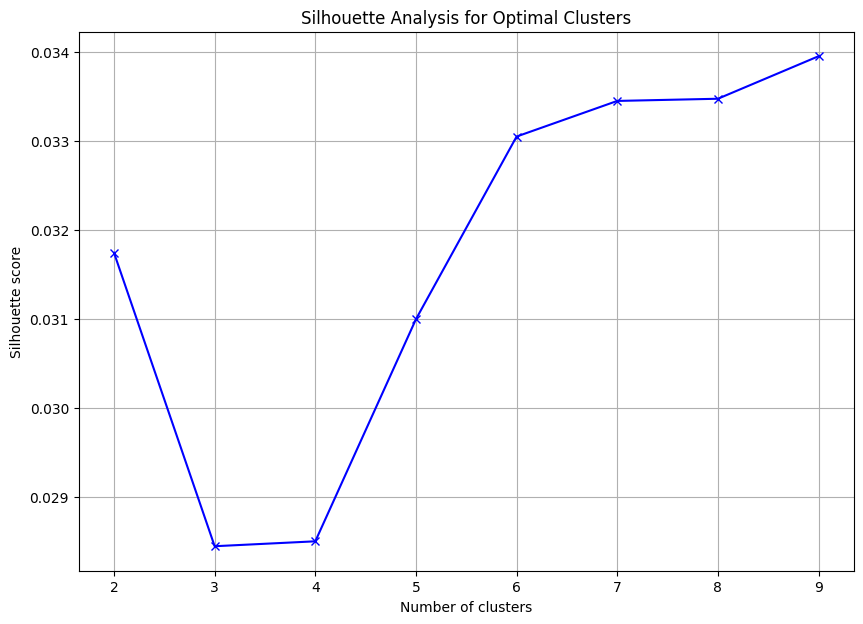

Optimal number of clusters: 9


In [4]:
# Edition 1.2

import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Directory containing the .mat files
data_dir = '/kaggle/input/dataset-hfw/Combined Dataset/Input'

# Initialize list to store channel matrices
channel_matrices = []

# Load .mat files
for file_name in os.listdir(data_dir):
    if file_name.endswith('.mat'):
        file_path = os.path.join(data_dir, file_name)
        mat_data = sio.loadmat(file_path)
        H = mat_data['H']  # Assuming the variable name in .mat file is 'H'
        channel_matrices.append(H)

# Convert list to numpy array for easier processing
channel_matrices = np.array(channel_matrices)  # Shape: (3000, 36, 144, 5)

# Flatten the matrices along the last three dimensions
# For complex numbers, separate real and imaginary parts
flattened_matrices = np.concatenate([channel_matrices.real, channel_matrices.imag], axis=-1)
flattened_matrices = flattened_matrices.reshape(3000, -1)

# Determine optimal number of clusters using silhouette score
range_n_clusters = list(range(2, 10))  # We will check for clusters from 2 to 9
silhouette_avg = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(flattened_matrices)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(flattened_matrices, cluster_labels))

# Plot the silhouette scores for different numbers of clusters
plt.figure(figsize=(10, 7))
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis for Optimal Clusters')
plt.grid(True)
plt.show()

# Identify the optimal number of clusters
optimal_clusters = range_n_clusters[np.argmax(silhouette_avg)]
print(f'Optimal number of clusters: {optimal_clusters}')
